In [30]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual, Output
from IPython.display import display, Image
import plotly.express as px
import plotly.graph_objects as go
import math
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("df_cleaned.csv", index_col=[0])

In [4]:
flex_title = "Santé Publique France"
flex_subtitle = "Open Food Facts"

In [5]:
df_filtered = df.copy()
ALL = "Tout"
axis_options = ["energy_100g",
           "fat_100g",
           "saturated-fat_100g",
           "trans-fat_100g",
           "cholesterol_100g",
           "carbohydrates_100g",
           "sugars_100g",
           "fiber_100g",
           "proteins_100g",
           "salt_100g",
           "sodium_100g",
           "vitamin-a_100g",
           "vitamin-c_100g",
           "calcium_100g",
             "iron_100g",
             "nutrition-score-fr_100g"]

filter_options = [
                 "brands",
                  "pnns_groups_1",
                  "nutrition_grade_fr"]

filter_trad = {
    "packaging" : "packaging",
    "brands" : "marque",
    "categories" : "categorie",
    "pnns_groups_1" : "catégorie",
    "pnns_groups_2" : "groupe PNNS (version 2)",
    "main_category" : "categorie principale",
    "nutrition_grade_fr" : "nutri-score",
    "product_name" :  "dénomination",
    "countries_fr": "pays de vente",
    "ingredients_text": "ingrédients",
    "ingredients_from_palm_oil_n": "nombre d'ingrédients provenant de l'huile de palme"
}
nutriscore_url = {
    "a": "https://nutriscore.colruytgroup.com/colruytgroup/img/nutriscore-a.png",
    "b": "https://nutriscore.colruytgroup.com/colruytgroup/img/nutriscore-b.png",
    "c": "https://nutriscore.colruytgroup.com/colruytgroup/img/nutriscore-c.png",
    "d": "https://nutriscore.colruytgroup.com/colruytgroup/img/nutriscore-d.png",
    "e": "https://nutriscore.colruytgroup.com/colruytgroup/img/nutriscore-e.png"
}
color_map = {
        "a": "#037D3F",
        "b": "#81B52E",
        "c": "#F6C502",
        "d": "#E77D00",
        "e": "#DF3C10",
        np.nan: "black"
    }
df_filtered["color"] = df_filtered["nutrition_grade_fr"].map(color_map)
dropdowns = {}
axis = {}
components = []
components_axis = []
nb_select = widgets.HTML(value="Nombre de produits selectionnés : {}".format(df_filtered.shape[0]))

def on_value_change(change):
    global df_filtered
    dropdown_name = ""
    out.clear_output()
    with out:
        print("nouvelle valeur : {}".format(change["new"]))
        print("ancienne valeur : {}".format(change["old"]))
#         print(change.owner)
#         print(components[5])
        if(change.owner == components[1]):
            print("marque a changé !!")
            dropdown_name = "brands"
            
        if(change.owner == components[3]):
            print("pnns_groups_1 a changé")
            dropdown_name = "pnns_groups_1"

        if(change.owner == components[5]):
            print("nutri-score a changé")
            dropdown_name = "nutrition_grade_fr"
        if(change["new"] == ALL):
            dropdowns[dropdown_name]["filter"] = df[dropdown_name]
            print(dropdowns[dropdown_name]["filter"])
        else:
            dropdowns[dropdown_name]["filter"] = change["new"]
        print("brand : {}".format(dropdowns["brands"]["filter"]))
        print("pnns  : {}".format(dropdowns["pnns_groups_1"]["filter"]))
        print("nutri : {}".format(dropdowns["nutrition_grade_fr"]["filter"]))
        df_filtered = df.loc[(df["brands"]==dropdowns["brands"]["filter"]) &
                            (df["pnns_groups_1"]==dropdowns["pnns_groups_1"]["filter"]) &
                            (df["nutrition_grade_fr"]==dropdowns["nutrition_grade_fr"]["filter"])].copy()
        df_filtered["color"] = df_filtered["nutrition_grade_fr"].map(color_map)
        fig.data[0]['x'] = df_filtered[axis['X']['selected']]
        fig.data[0]['y'] = df_filtered[axis['Y']['selected']]
        fig.data[0]['marker']['color'] = df_filtered["color"]
        fig.data[0]['text'] = df_filtered["product_name"]
        nb_select.value = "Nombre de produits selectionnés : {}".format(df_filtered.shape[0])
#         fig.data[0]['marker']['color'] = "pink"
    pass

def on_axis_change(change):
    out.clear_output()
    if(change.owner == components_axis[1]):
        fig.data[0]['x'] = df_filtered[change.new]
        axis['X']['selected'] = change.new
        with out:
            print("axe X a changé")
    if(change.owner == components_axis[3]):
        fig.data[0]['y'] = df_filtered[change.new]
        axis['Y']['selected'] = change.new
        with out:
            print("axe Y a changé")
    fig.data[0]['marker']['color'] = df_filtered["color"]
    return

def get_filter_options(df, col):
    return sorted(df[col].loc[df[col].notna()].unique().tolist())

def make_dropdown(col):
    lbl = widgets.HTML(value=filter_trad[col])
    opts = get_filter_options(df, col)
    opts.insert(0, ALL)
    widget = widgets.Dropdown(options=opts, value=opts[0])
    dropdown = {
        "name" : col,
        "label": lbl,
        "options": opts,
        "widget": widget,
        "filter": df[col]
    }
    return dropdown

def make_axis_dropdown(ls, name, nb_selected=0):
    lbl = widgets.HTML(value=name)
    opts = ls
    widget = widgets.Dropdown(options=opts, value=opts[nb_selected])
    dropdown = {
        "name" : name,
        "label": lbl,
        "options": opts,
        "widget": widget,
        "selected": opts[nb_selected]
    }
    return dropdown

def init_axis():
    global axis
    axis["X"] = make_axis_dropdown(axis_options, "axe X", 0)
    axis["X"]["widget"].observe(on_axis_change, names="value")
    components_axis.extend([axis["X"]["label"], axis["X"]["widget"]])
    axis["Y"] = make_axis_dropdown(axis_options, "axe Y", -1)
    axis["Y"]["widget"].observe(on_axis_change, names="value")
    components_axis.extend([axis["Y"]["label"], axis["Y"]["widget"]])
    

def init_filter_dropdowns():
    global dropdowns
    global controls
    for opt in filter_options:
        dropdowns[opt] = make_dropdown(opt)
        dropdowns[opt]["widget"].observe(on_value_change, names="value")
        components.extend([dropdowns[opt]["label"], dropdowns[opt]["widget"]])



# brands = make_dropdown("brands")
init_filter_dropdowns()
init_axis()
# widgets.VBox([brands["label"], brands["widget"]])
filt_label = widgets.HTML(value="<h3>Filtres : </h3>")
axis_label = widgets.HTML(value="<h3>Axes : </h3>")
filt_widgets = widgets.VBox(components)
axis_widgets = widgets.VBox(components_axis)

left_panel = widgets.VBox([filt_label, filt_widgets, axis_label, axis_widgets])

fig = go.FigureWidget()
plot = go.Scatter(x=[], 
                  y=[], 
                  mode="markers", 
                  text=[], 
                  hoverinfo="text", 
                  marker=dict(color=[], opacity=[], size=7))
fig.add_trace(plot)

margin = go.layout.Margin(l=20, r=20, b=20, t=30)

fig = fig.update_layout(margin=margin)
fig.data[0]['text'] = df_filtered["product_name"]
fig.data[0]['x'] = df_filtered[axis['X']['selected']]
fig.data[0]['y'] = df_filtered[axis['Y']['selected']]
fig.data[0]['marker']['color'] = df_filtered["color"]
# fig.layout.hovermode = 'closest'

out = Output()

# graph = widgets.VBox([fig, out])
# graph
# fig
# fig_zone = widgets.HBox([left_panel, graph])

# widgets.VBox([fig_zone, nb_select])

## Contrôles

In [6]:
left_panel

## Figure

In [7]:
fig

FigureWidget({
    'data': [{'hoverinfo': 'text',
              'marker': {'color': [#DF3C10, black, #E77D00, …

In [91]:
search_bar = widgets.Text(
    value="",
    placeholder="Entrez l'aliment recherché",
    description="Rechercher:",
    disabled=False
)

search_button = widgets.Button(
    description="Chercher",
    disabled=False,
    button_style="info",
    tooltip="Cliquez pour rechercher",
    icon="search"
)


def tag(tag_name, attr, content):
    return "<{} {}>{}</{}>".format(tag_name, attr, content, tag_name)

def tag_list(tag_name, attr, content_list):
    res=""
    for item in content_list:
        res+= tag(tag_name, attr, item)
    return res



def on_button_clicked(b):
#     search_result.value = search_bar.value
#     df_res = df.loc[df["product_name"].dropna().str.contains(str(search_bar.value), case=False)]
    df_res = df.dropna(subset=["product_name"]).loc[df["product_name"].dropna().str.contains(search_bar.value)]
    res = ""
    for index, row in df_res.iterrows():
        res += make_card(row)
#     search_result.value = make_card(df_res.iloc[0])
    search_result.value = res

search_button.on_click(on_button_clicked)
search_tool = widgets.HBox([search_bar, search_button])
search_result = widgets.HTML(value="Résultat : </br>")
# widgets.VBox([search_tool, search_result])

In [90]:
card_cols = [
    "product_name",
    "brands",
    "countries_fr",
    "pnns_groups_1",
    "ingredients_text",
    "ingredients_from_palm_oil_n",
    "nutrition_grade_fr"
]
table_css = "style:'border-collapse:collapse!important; width:100%; max-width:100%; margin-bottom:1rem;'"
tbl_css = "border-collapse:collapse!important; width:100%; max-width:100%; margin-bottom:1rem;"
td_css = "style:'padding:.75rem;'"
th_css = "style:'text-align:inherit;'"
tr_css = "style:'page-break-inside:avoid;'"

def out_img(url, width=300, height=400):
    image = Image(url)
    img_widget = widgets.Image(
        value=image.data,
        format="jpg",
        width=width,
        height=height
    )
    return img_widget

def plot_nutri(df, index):
    cols = ["fat_100g", 
        "carbohydrates_100g", 
        "saturated-fat_100g", 
        "sugars_100g", 
        "fiber_100g", 
        "salt_100g", 
        "proteins_100g",
        "iron_100g", 
        "fruits-vegetables-nuts_100g",
        "vitamin-d_100g", 
        "vitamin-c_100g"]
    df_tmp = df[cols].iloc[0].copy()
    cols_to_keep = df_tmp.dropna().index.tolist()
    g = sns.barplot(x = df[cols_to_keep].columns, y = df[cols_to_keep].iloc[index])
    g.bar_label(g.containers[0])
    g.set(ylabel="quantité pour 100g", xlabel="nutriments", title="quantité de nutriments pour 100g")
    myplot = plt.xticks(rotation=90)
    return myplot

def nutri_table(df, index):
    cols = ["fat_100g", 
        "carbohydrates_100g", 
        "saturated-fat_100g", 
        "sugars_100g", 
        "fiber_100g", 
        "salt_100g", 
        "proteins_100g",
        "iron_100g", 
        "fruits-vegetables-nuts_100g",
        "vitamin-d_100g", 
        "vitamin-c_100g"]
    df_tmp = df[cols].iloc[index].copy()
    cols_to_keep = df_tmp.dropna().index.tolist()
    res = df_tmp[cols_to_keep].to_frame(name="nutriments pour 100g").to_html()
    return res.replace("\n", "")

def make_card_row(col, row):
    th = tag("th", "scope='col' {}".format(th_css), tag("b", "", filter_trad[col]+"&nbsp;&nbsp;&nbsp;"))
    if (row[col] != "nan") & (row[col] != np.nan) & (not pd.isna(row[col])):
        td = tag("td", td_css, row[col])
    else:
        td = tag("td", td_css, "Non disponible")
    content = th + td
    tr = tag("tr", tr_css, content)
    return tr

def make_nutri_row(row):
    return

def make_nutrigrade_row(row):
    col = "nutrition_grade_fr"
    th = tag("th", "scope='col' {}".format(th_css), tag("b", "", filter_trad[col]+"&nbsp;&nbsp;&nbsp;"))
    if (row[col] != "nan") & (row[col] != np.nan) & (not pd.isna(row[col])):
        td = tag("td", td_css, "<img src='{}' />".format(nutriscore_url[row[col]]))
    else:
        td = tag("td", td_css, "Non disponible")
    content = th + td
    tr = tag("tr", tr_css, content)
    return tr



def img_row(row):
    td = tag("td", "colspan='2' style='text-align: center'", "<img src='{}' />".format(row["image_url"]))
    tr = tag("tr", "", td)
    return tr

def make_card(row):
    content = ""
    content += img_row(row)
    for item in card_cols:
        if item == "nutrition_grade_fr":
            item_row = make_nutrigrade_row(row)
        else:
            item_row = make_card_row(item, row)
        content += item_row
    nutrigrade = row["nutrition_grade_fr"]
    color_class = ""
    if nutrigrade in ["a", "b", "c", "d", "e"]:
        bg_color = color_map[nutrigrade]
        bg_color = "background:{}; color: #FFFFFF;".format(bg_color)
    else:
        bg_color = "#FFFFFF"
        bg_color = "background:{}; color: #000000;".format(bg_color)
    if (nutrigrade == "a") | (nutrigrade == "b"):
        color_class = "bg-success"
    if (nutrigrade == "c") | (nutrigrade == "d"):
        color_class = "bg-warning"
    if (nutrigrade == "e"):
        color_class = "bg-danger"
    table = "<table class='table {}' style='{}'>{}</table>".format(color_class, bg_color+tbl_css, content)
    return table


## Rechercher un produit

In [92]:
# widgets.HTML(value=tag("h2", "", "Rechercher un produit"))
# widgets.HTML(value='<link href="https://cdn.jsdelivr.net/npm/bootstrap@5.1.3/dist/css/bootstrap.min.css" rel="stylesheet" integrity="sha384-1BmE4kWBq78iYhFldvKuhfTAU6auU8tT94WrHftjDbrCEXSU1oBoqyl2QvZ6jIW3" crossorigin="anonymous">')
# widgets.HTML(value='<script src="https://cdn.jsdelivr.net/npm/bootstrap@5.1.3/dist/js/bootstrap.bundle.min.js" integrity="sha384-ka7Sk0Gln4gmtz2MlQnikT1wXgYsOg+OMhuP+IlRH9sENBO0LRn5q+8nbTov4+1p" crossorigin="anonymous"></script>')
widgets.VBox([search_tool, search_result])

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'fat_100g'),
  Text(1, 0, 'carbohydrates_100g'),
  Text(2, 0, 'saturated-fat_100g'),
  Text(3, 0, 'sugars_100g'),
  Text(4, 0, 'fiber_100g'),
  Text(5, 0, 'salt_100g'),
  Text(6, 0, 'proteins_100g'),
  Text(7, 0, 'iron_100g')])

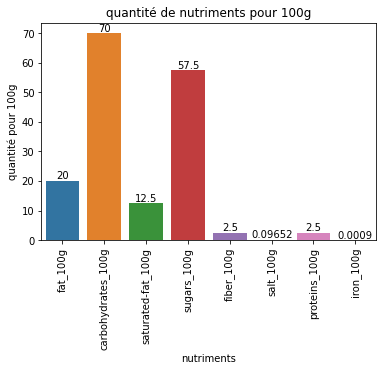

In [47]:
# nécessiterait une exportation pour être ajouté à la fiche produit

cols = ["fat_100g", 
        "carbohydrates_100g", 
        "saturated-fat_100g", 
        "sugars_100g", 
        "fiber_100g", 
        "salt_100g", 
        "proteins_100g",
        "iron_100g"]
df[cols].iloc[0]
g = sns.barplot(x = df[cols].columns, y = df[cols].iloc[0])
g.bar_label(g.containers[0])
g.set(ylabel="quantité pour 100g", xlabel="nutriments", title="quantité de nutriments pour 100g")
plt.xticks(rotation=90)